In [12]:
pip install -U tensorflow-addons


Note: you may need to restart the kernel to use updated packages.


In [13]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import tqdm
import os
print(os.listdir("../input"))
import glob
import cv2
import tensorflow as tf
from keras import layers
from keras.layers import Dropout , Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
from sklearn.model_selection import train_test_split
import keras.backend as K
from sklearn.utils import shuffle

['cell-images-for-detecting-malaria']


In [14]:
#!pip install imutils


In [15]:
import numpy as np
import pandas as pd
from scipy.spatial import distance as dist
import matplotlib.pyplot as plt
import os
import cv2
import seaborn as sns
from tqdm import tqdm 
from sklearn.utils import shuffle
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
import keras
from keras.applications.vgg16 import VGG16 
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.models import Sequential, Model 
from keras.applications import DenseNet201
from keras.initializers import he_normal
from keras.layers import Lambda, SeparableConv2D, BatchNormalization, Dropout, MaxPooling2D, Input, Dense, Conv2D, Activation, Flatten 
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


In [16]:
from __future__ import absolute_import, division, print_function
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os

In [17]:
infected = os.listdir('../input/cell-images-for-detecting-malaria/cell_images/Parasitized/') 
uninfected = os.listdir('../input/cell-images-for-detecting-malaria/cell_images/Uninfected/')


In [18]:
data = []
labels = []

for i in tqdm(infected):
    try:
    
        image = cv2.imread("../input/cell-images-for-detecting-malaria/cell_images/Parasitized/"+i)
        image_array = Image.fromarray(image , 'RGB')
        resize_img = image_array.resize((60 , 60))
        #rotated45 = resize_img.rotate(45)
        #rotated75 = resize_img.rotate(75)
        #blur = cv2.blur(np.array(resize_img) ,(10,10))
        data.append(np.array(resize_img))
        #data.append(np.array(rotated45))
        #data.append(np.array(rotated75))
        #data.append(np.array(blur))
        labels.append(1)
        #labels.append(1)
        #labels.append(1)
        #labels.append(1)
        
    except AttributeError:
        print('')
    
for u in tqdm(uninfected):
    try:
        
        image = cv2.imread("../input/cell-images-for-detecting-malaria/cell_images/Uninfected/"+u)
        image_array = Image.fromarray(image , 'RGB')
        resize_img = image_array.resize((60 , 60))
        #rotated45 = resize_img.rotate(45)
        #rotated75 = resize_img.rotate(75)
        data.append(np.array(resize_img))
        #data.append(np.array(rotated45))
        #data.append(np.array(rotated75))
        labels.append(0)
        #labels.append(0)
        #labels.append(0)
        
    except AttributeError:
        print('')


 68%|██████▊   | 9331/13780 [00:17<00:07, 593.43it/s]

 66%|██████▋   | 9153/13780 [01:26<00:38, 118.81it/s]

100%|██████████| 13780/13780 [02:09<00:00, 106.75it/s]


In [19]:
cells = np.array(data)
labels = np.array(labels)

#np.save('Cells' , cells)
#np.save('Labels' , labels)


In [20]:
print('Cells : {} | labels : {}'.format(cells.shape , labels.shape))


Cells : (27558, 60, 60, 3) | labels : (27558,)


In [21]:
n = np.arange(cells.shape[0])
np.random.shuffle(n)
cells = cells[n]
labels = labels[n]

In [22]:
cells = cells.astype(np.float32)
labels = labels.astype(np.int32)
#cells = cells/255

In [23]:
X_train,X_test,Y_train,Y_test = train_test_split(cells,labels,test_size = 0.25 , random_state =42)


In [24]:
num_classes = 2
input_shape = (60, 60, 3)



In [42]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 60
image_size = 60  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024, 512 , 256 , 128 , 64 , 32, 16]  # Size of the dense layers of the final classifier


In [26]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.Normalization(),
        layers.experimental.preprocessing.Resizing(image_size, image_size),
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(factor=0.02),
        layers.experimental.preprocessing.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(X_train)


In [27]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x
del cells , labels

In [28]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


Image size: 60 X 60
Patch size: 6 X 6
Patches per image: 100
Elements per patch: 108


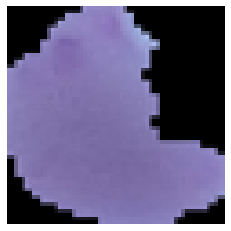

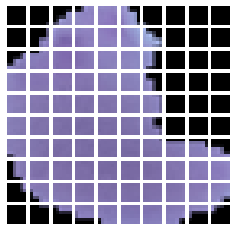

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = X_train[np.random.choice(range(X_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")


In [30]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


In [31]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [44]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy")
        ]
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True
    )

    history = model.fit(
        x=X_train,
        y=Y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.25,
        callbacks=[checkpoint_callback]
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(X_test, Y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    #print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)


Epoch 1/60
61/61 [==============================] - 23s 204ms/step - loss: 1.1615 - accuracy: 0.5033 - top-5-accuracy: 1.0000 - val_loss: 0.6938 - val_accuracy: 0.5071 - val_top-5-accuracy: 1.0000
Epoch 2/60
61/61 [==============================] - 11s 180ms/step - loss: 0.7305 - accuracy: 0.5082 - top-5-accuracy: 1.0000 - val_loss: 0.6955 - val_accuracy: 0.5071 - val_top-5-accuracy: 1.0000
Epoch 3/60
61/61 [==============================] - 11s 178ms/step - loss: 0.7123 - accuracy: 0.5065 - top-5-accuracy: 1.0000 - val_loss: 0.6939 - val_accuracy: 0.5071 - val_top-5-accuracy: 1.0000
Epoch 4/60
61/61 [==============================] - 11s 179ms/step - loss: 0.7020 - accuracy: 0.5051 - top-5-accuracy: 1.0000 - val_loss: 0.6949 - val_accuracy: 0.5071 - val_top-5-accuracy: 1.0000
Epoch 5/60
61/61 [==============================] - 11s 178ms/step - loss: 0.7015 - accuracy: 0.5045 - top-5-accuracy: 1.0000 - val_loss: 0.6938 - val_accuracy: 0.5071 - val_top-5-accuracy: 1.0000
Epoch 6/60
61/6